Firstly, in this section, I am importing the necessary libraries for data manipulation, visualization, text processing, and machine learning models.

In [1]:
# Data manipulation
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

Now, let's download the train data

In [2]:
# Loading data from a CSV file
data = pd.read_csv('c:\\Users\\Dima\\Desktop\\train.csv')

In [3]:
# Getting and displaying dataset information
data_info = data.info()

# Getting and displaying the first few rows of the dataset
data_head = data.head()

# Printing both dataset information and the first few rows
print("Dataset Information:", data_info)
print("\nFirst Few Rows of the Dataset:", data_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB
Dataset Information: None

First Few Rows of the Dataset:                                               review sentiment
0  I caught this little gem totally by accident b...  positive
1  I can't believe that I let myself into this mo...  negative
2  *spoiler alert!* it just gets to me the nerve ...  negative
3  If there's one thing I've learnt from watching...  negative
4  I remember when this was in theaters, reviews ...  negative


In our dataset, comprising 40,000 records, we observe two key columns: "review" and "sentiment," indicating positive or negative sentiment. Notably, there are no missing values, laying a solid foundation. The next step involves delving into exploratory data analysis (EDA).

* Conduct Sentiment Distribution Analysis: Examine the distribution of sentiment to identify any imbalances between positive and negative reviews.

* Review Length Analysis: Assess the distribution of review lengths and investigate potential disparities between positive and negative reviews in terms of their length.

* Data Visualization: Generate visualizations to enhance the comprehension of the data, providing insightful representations for a more comprehensive understanding.

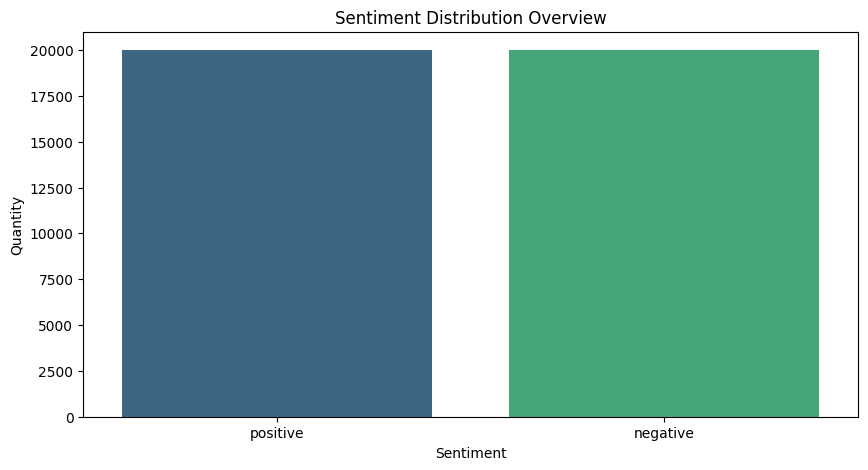

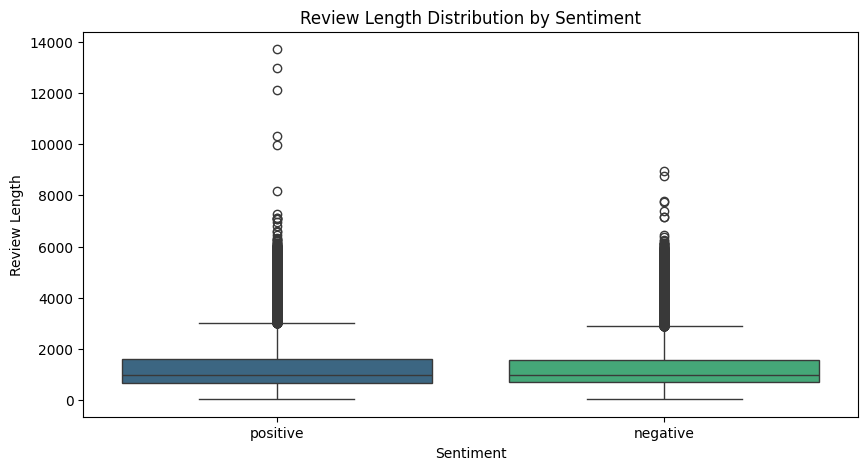

In [6]:
# Analyzing Sentiment Distribution
sentiment_counts = data['sentiment'].value_counts()

# Review Length Analysis
data['review_length'] = data['review'].apply(len)
length_describe = data.groupby('sentiment')['review_length'].describe()

# Visualizing Sentiment Distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, hue=sentiment_counts.index, palette="viridis", legend=False)
plt.title('Sentiment Distribution Overview')
plt.ylabel('Quantity')
plt.xlabel('Sentiment')
plt.show()

# Visualizing Review Length Distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='sentiment', y='review_length', data=data, hue='sentiment', palette="viridis", dodge=False, legend=False)
plt.title('Review Length Distribution by Sentiment')
plt.ylabel('Review Length')
plt.xlabel('Sentiment')
plt.show()


* The dataset showcases a balanced distribution, containing 20,000 examples of both positive and negative reviews. This equilibrium in class representation streamlines the modeling process by avoiding class imbalance challenges.

* Reviewing the average length, it stands at approximately 1300 characters for both positive and negative categories. Despite this consistency, there exists notable variability in review lengths. This is evident in the substantial difference between the 25% and 75% quartiles, coupled with the presence of outliers. While there are slight variations in length between positive and negative reviews, these differences appear to be inconsequential.

Key Observations:
Class Balance: Our analysis reveals an ideal equilibrium between positive and negative feedback within the dataset. This balanced distribution is a favorable characteristic for effective model training.
Review Length: The observed variability in review lengths can introduce implications for the text vectorization process. It underscores the potential necessity to consider trimming or augmenting texts when employing certain machine learning models.

Next, let's proceed with text pre-processing. This involves eliminating superfluous links, as they don't contribute valuable information. Additionally, we'll remove non-alphabetic characters, convert the text to lowercase, tokenize, and eliminate stop words. Given our objective to compare stemming versus lemmatization, we will implement both techniques for further evaluation.

In [7]:
# Downloading necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Defining stopwords, lemmatizer, and stemmer
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

# Function for cleaning reviews
def clean_review(review_text):
    # Remove URLs
    review_text = re.sub(r'http\S+', '', review_text)
    # Remove non-alphabetic characters
    review_text = re.sub('[^a-zA-z]', ' ', review_text)
    # Convert to lowercase
    review_text = review_text.lower()
    # Tokenization
    tokens = word_tokenize(review_text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemma_tokens = [lemma.lemmatize(word=w, pos='v') for w in tokens]
    # Stemming
    stem_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(lemma_tokens), ' '.join(stem_tokens)

# Applying the cleaning function to the dataset
data['CleanReview_Lemma'], data['CleanReview_Stem'] = zip(*data['review'].apply(clean_review))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now, let's visualize the top 20 most popular words in the reviews.

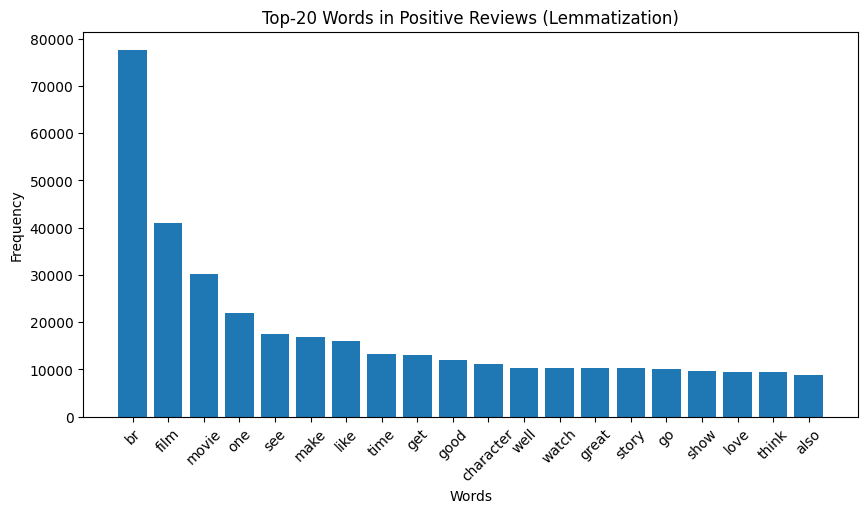

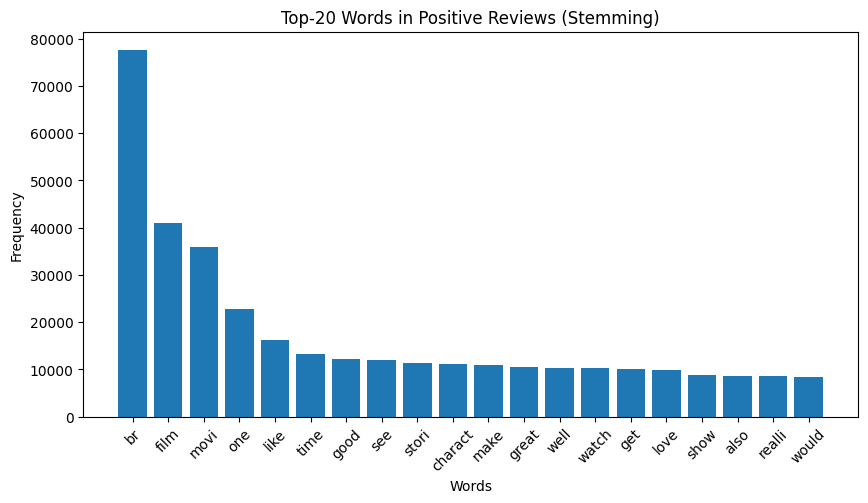

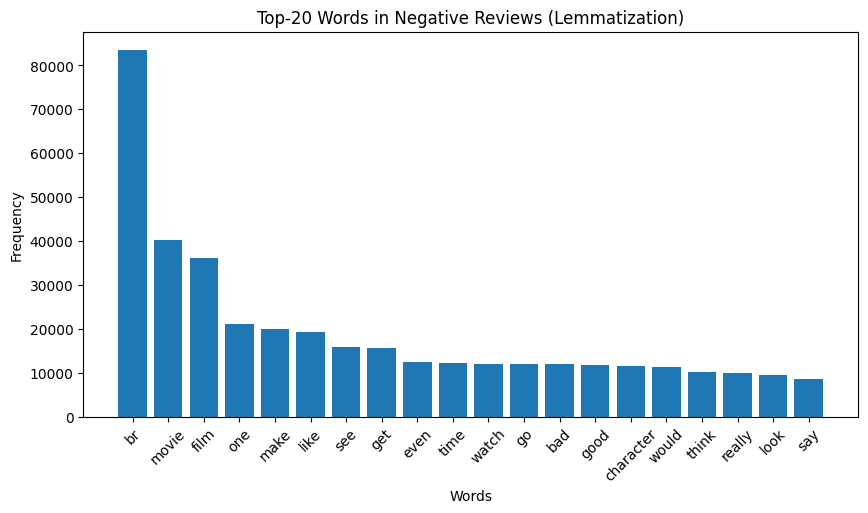

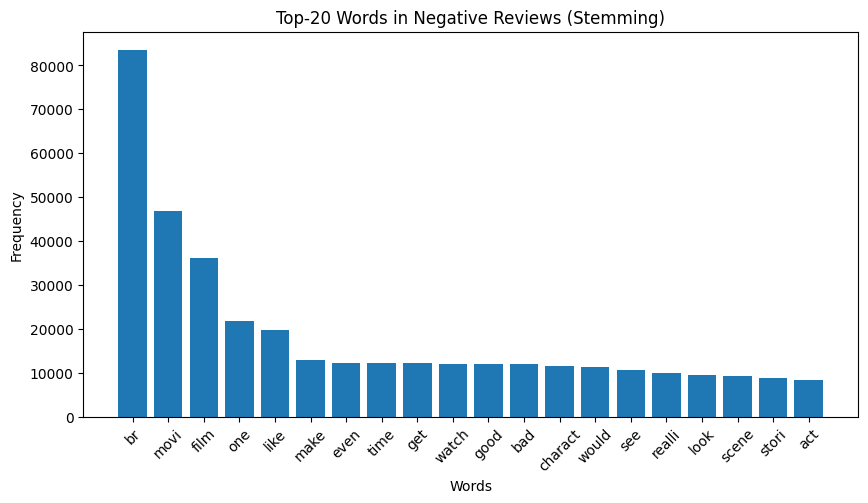

In [8]:
from collections import Counter

def plot_top_words(data, column, sentiment, n=20):
    # Select reviews based on sentiment and specified column
    reviews = data[data['sentiment'] == sentiment][column]
    
    # Combine text and split it into words
    words = ' '.join(reviews).split()
    
    # Count the frequency of each word
    word_freq = Counter(words)
    
    # Select the top-N words
    top_words = word_freq.most_common(n)
    
    # Visualization
    top_words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(top_words, counts)
    plt.title(f"Top-{n} Words in {'Positive' if sentiment == 'positive' else 'Negative'} Reviews ({'Lemmatization' if column == 'CleanReview_Lemma' else 'Stemming'})")
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.show()

# Using the function for visualization
plot_top_words(data, 'CleanReview_Lemma', 'positive', 20)
plot_top_words(data, 'CleanReview_Stem', 'positive', 20)
plot_top_words(data, 'CleanReview_Lemma', 'negative', 20)
plot_top_words(data, 'CleanReview_Stem', 'negative', 20)


Here, an observation surfaces indicating an excess of "br" words, likely remnants from HTML. To address this redundancy, let's enhance our `clean_review` function to include the removal of these unnecessary tags.

Observation: It is evident from our analysis that certain words such as "film," "movie," and "one" are pervasive across all labels and exhibit the highest frequency. Considering this, a prudent approach would involve removing these common words from our corpus to enhance model performance.

In [9]:
# Downloading necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Defining stopwords, lemmatizer, and stemmer
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review(review_text):
    # Remove URLs
    review_text = re.sub(r'http\S+', '', review_text)
    # Remove non-alphabetic characters
    review_text = re.sub('[^a-zA-z]', ' ', review_text)
    # Convert to lowercase
    review_text = review_text.lower()
    # Tokenization
    tokens = word_tokenize(review_text)
    # Remove stop words and specified common words
    tokens = [word for word in tokens if word not in stop_words and word not in ['film', 'movie', 'br', 'one']]
    # Lemmatization
    lemma_tokens = [lemma.lemmatize(word=w, pos='v') for w in tokens]
    # Stemming
    stem_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(lemma_tokens), ' '.join(stem_tokens)

# Applying the enhanced cleaning function to the dataset
data['CleanReview_Lemma'], data['CleanReview_Stem'] = zip(*data['review'].apply(clean_review))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dima\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's revisit the visualization process.

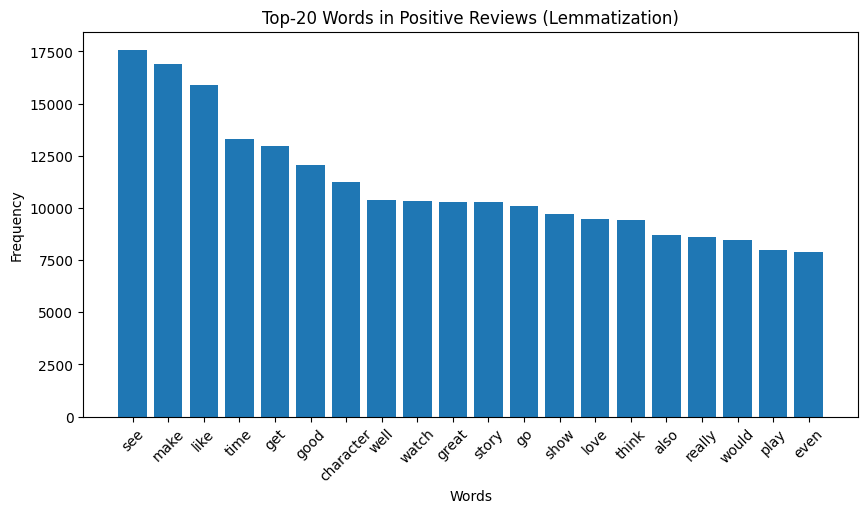

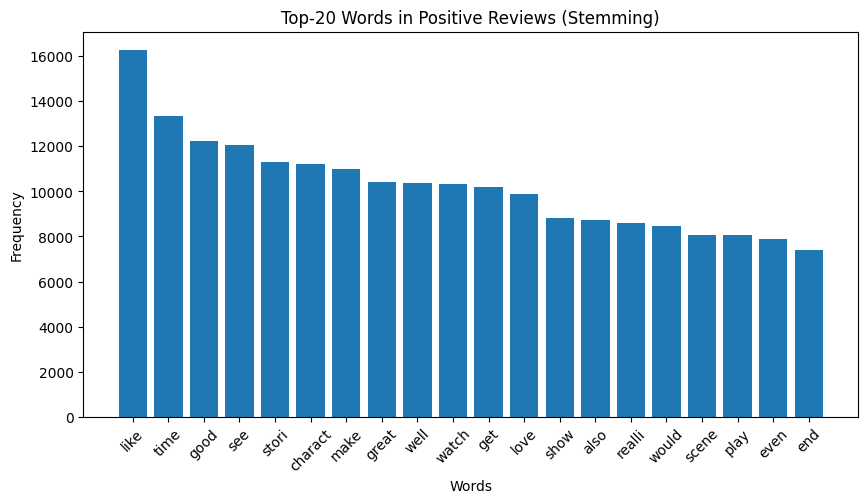

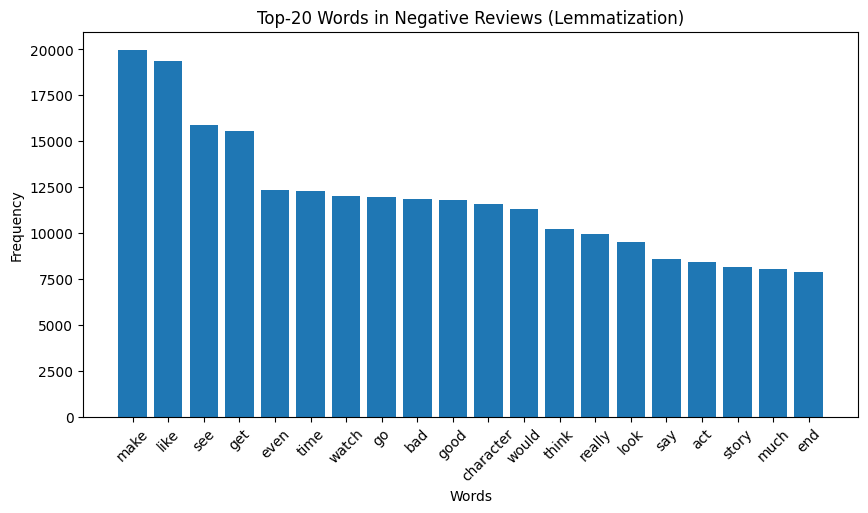

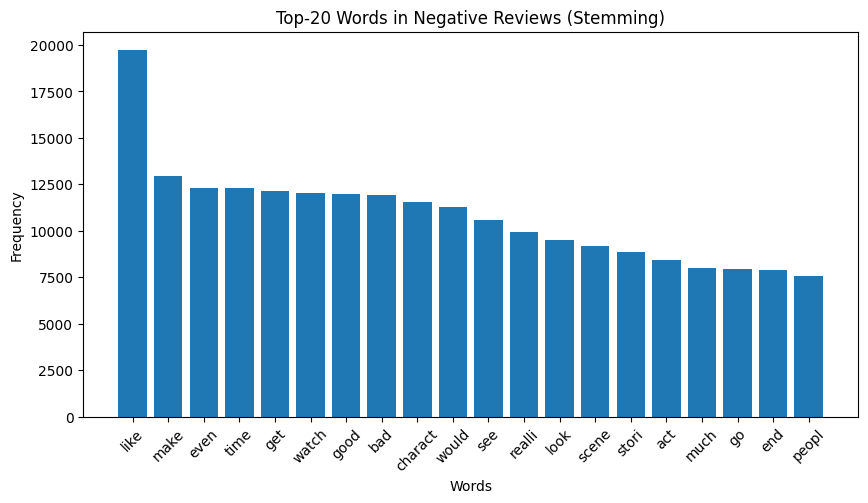

In [10]:
plot_top_words(data, 'CleanReview_Lemma', 'positive', 20)
plot_top_words(data, 'CleanReview_Stem', 'positive', 20)
plot_top_words(data, 'CleanReview_Lemma', 'negative', 20)
plot_top_words(data, 'CleanReview_Stem', 'negative', 20)

Let's proceed with the vectorization phase, where we'll compare two methods: Count Vectorizer and TF-IDF Vectorization.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorization for lemmatized data
# CountVectorizer
count_vectorizer_lem = CountVectorizer(max_features=5000)
X_counts_lem = count_vectorizer_lem.fit_transform(data['CleanReview_Lemma'])

# TF-IDF Vectorizer
tfidf_vectorizer_lem = TfidfVectorizer(max_features=5000)
X_tfidf_lem = tfidf_vectorizer_lem.fit_transform(data['CleanReview_Lemma'])

# Vectorization for stemmed data
# CountVectorizer
count_vectorizer_stem = CountVectorizer(max_features=5000)
X_counts_stem = count_vectorizer_stem.fit_transform(data['CleanReview_Stem'])

# TF-IDF Vectorizer
tfidf_vectorizer_stem = TfidfVectorizer(max_features=5000)
X_tfidf_stem = tfidf_vectorizer_stem.fit_transform(data['CleanReview_Stem'])


For comparative analysis, let's construct a Logistic Regression model incorporating both vectorization methods (Count Vectorizer and TF-IDF Vectorization). We'll evaluate their performance and compare the accuracy of each approach.

In [12]:
# Function for model evaluation
def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Convert sentiment to numeric values
data['sentiment_code'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y = data['sentiment_code']

# Models using lemmatization
accuracy_count_lemma = evaluate_model(X_counts_lem, y, LogisticRegression(max_iter=1000))
accuracy_tfidf_lemma = evaluate_model(X_tfidf_lem, y, LogisticRegression(max_iter=1000))

# Models using stemming
accuracy_count_stem = evaluate_model(X_counts_stem, y, LogisticRegression(max_iter=1000))
accuracy_tfidf_stem = evaluate_model(X_tfidf_stem, y, LogisticRegression(max_iter=1000))

# Displaying the results
print(f'Accuracy (Count Vectorizer + Lemmatization): {accuracy_count_lemma}')
print(f'Accuracy (TF-IDF Vectorization + Lemmatization): {accuracy_tfidf_lemma}')
print(f'Accuracy (Count Vectorizer + Stemming): {accuracy_count_stem}')
print(f'Accuracy (TF-IDF Vectorization + Stemming): {accuracy_tfidf_stem}')


Accuracy (Count Vectorizer + Lemmatization): 0.860875
Accuracy (TF-IDF Vectorization + Lemmatization): 0.884375
Accuracy (Count Vectorizer + Stemming): 0.864125
Accuracy (TF-IDF Vectorization + Stemming): 0.882375


Given the similarity in performance metrics across all models, let's enhance our model evaluation function to incorporate additional metrics for a more comprehensive analysis.

In [13]:
def evaluate_model(X, y, model, test_size=0.2, random_state=42):
    """
    Evaluates the performance of the given model using various metrics.

    Parameters:
    - X: Feature matrix
    - y: Target variable
    - model: Machine learning model
    - test_size: Percentage of data to use for testing (default: 0.2)
    - random_state: Seed for reproducibility (default: 42)

    Returns:
    - Tuple of accuracy, recall, precision, and F1 score
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, recall, precision, f1

# Model Evaluation and Results Compilation
results = []

# Count Vectorizer with Lemmatization
metrics_lemma = evaluate_model(X_counts_lem, y, LogisticRegression(max_iter=1000))
results.append(('Count Vectorizer + Lemmatization',) + metrics_lemma)

# TF-IDF Vectorization with Lemmatization
metrics_lemma_tfidf = evaluate_model(X_tfidf_lem, y, LogisticRegression(max_iter=1000))
results.append(('TF-IDF Vectorization + Lemmatization',) + metrics_lemma_tfidf)

# Count Vectorizer with Stemming
metrics_stem = evaluate_model(X_counts_stem, y, LogisticRegression(max_iter=1000))
results.append(('Count Vectorizer + Stemming',) + metrics_stem)

# TF-IDF Vectorization with Stemming
metrics_stem_tfidf = evaluate_model(X_tfidf_stem, y, LogisticRegression(max_iter=1000))
results.append(('TF-IDF Vectorization + Stemming',) + metrics_stem_tfidf)

# Displaying Results in a DataFrame
df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
df_results


,Model,Accuracy,Recall,Precision,F1 Score
0,Count Vectorizer + Lemmatization,0.860875,0.862301,0.860800,0.861550
1,TF-IDF Vectorization + Lemmatization,0.884375,0.896165,0.876309,0.886126
2,Count Vectorizer + Stemming,0.864125,0.868028,0.862231,0.865120
3,TF-IDF Vectorization + Stemming,0.882375,0.894671,0.873997,0.884213


* Among the four considered models, TF-IDF + Stem exhibits the highest accuracy and F1 score, positioning itself as the most effective. This method demonstrates notable precision and recall scores, indicating a well-rounded performance.

* TF-IDF + Lemma also delivers strong results, particularly excelling in recall, highlighting its proficiency in identifying positive samples.

* Count Vectorizer + Lemma and Count Vectorizer + Stem yield comparable outcomes, but their overall performance is slightly inferior to the TF-IDF models.

Considering these findings, TF-IDF emerges as the optimal choice for text vectorization in this context, irrespective of whether stemming or lemmatization is applied. TF-IDF + Stem stands out with the best overall performance, although the difference between stemming and lemmatization is not substantial.

In general, TF-IDF's ability to assign more meaningful weights to words based on their significance within the entire corpus contributes to its superior performance compared to Count Vectorizer in this scenario.

The selection between stemming and lemmatization may hinge on the specific requirements of our task and the prioritization of accuracy versus recall. For tasks emphasizing recall (e.g., when maximizing the identification of positive samples is crucial), opting for lemmatization with TF-IDF might be preferable. Conversely, in applications where accuracy takes precedence (e.g., minimizing false positives is crucial), choosing stemming with TF-IDF could be a more suitable strategy.

For subsequent phases of our work, let's proceed with the TF-IDF + Stem model, given its superior performance in the current evaluation. This choice aligns with the goal of maximizing the effectiveness of our text classification task.

Let's now seek the optimal hyperparameters for our model through a thorough tuning process.

In [14]:
# Defining the hyperparameter grid
param_grid = {
    'C': [2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5]
}

# Initializing the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Performing Grid Search for hyperparameter tuning
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tfidf_stem, y)

# Displaying the best hyperparameters and corresponding accuracy
print("The optimal hyperparameters:", grid_search.best_params_)
print("The corresponding best accuracy:", grid_search.best_score_)


The optimal hyperparameters: {'C': 2.6}
The corresponding best accuracy: 0.8847249999999999


Let's proceed by constructing a model using the optimal hyperparameters identified through the grid search, and subsequently, we will evaluate its performance.

In [15]:
# Constructing the model with the optimal hyperparameters
best_model = LogisticRegression(C=2.7, max_iter=1000)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_stem, y, test_size=0.2, random_state=42)

# Training the model on the training set
best_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Displaying the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.88275
Recall: 0.891683266932271
Precision: 0.8768364348677767
F1 Score: 0.8841975308641975

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.88      0.89      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



Our logistic regression model, utilizing hyperparameters with C=2.6 and TF-IDF for text vectorization incorporating stemming, has demonstrated commendable performance across various metrics. Let's delve into each metric for a more detailed examination:

* **Accuracy: 0.88275**
  - The model accurately classifies approximately 88.26% of cases. This is particularly noteworthy for a balanced classification task.

* **Recall: 0.89168**
  - With a recall exceeding 89%, the model effectively identifies positive cases. In the context of sentiment analysis, this indicates proficiency in discerning positive reviews.

* **Precision: 0.8768**
  - An accuracy of almost 88% signifies that among the cases classified as positive by the model, approximately 88% are genuinely positive. This precision is crucial, as misclassifying a negative review as positive can have adverse consequences.

* **F1 Score: 0.8841**
  - The F1 score, a harmonic mean between accuracy and recall, illustrates that the model evaluates reviews in a balanced manner.

The classification report further emphasizes the model's balanced performance for both classes (positive and negative reviews), highlighting its efficacy across various aspects.

Conclusions:
* The model showcases impressive accuracy and well-balanced metrics, establishing its reliability for the sentiment classification task.
* The elevated recall underscores the model's proficiency in effectively detecting positive reviews while sustaining a high level of accuracy.
* The balanced metrics for both classes signify the model's consistent performance, demonstrating equal effectiveness in handling both positive and negative reviews.

In summary, this model appears robust and suitable for deployment in sentiment analysis tasks where achieving a balanced identification of both positive and negative reviews is crucial.

Now let's try the C-Support Vector Classification model

In [16]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_stem, y, test_size=0.2, random_state=42)

# Initializing the Linear Support Vector Classification model
svm_model = LinearSVC(random_state=42)

# Training the model on the training set
svm_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Displaying the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


c:\Users\Dima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.877
Recall: 0.8832171314741036
Precision: 0.8732151649433777
F1 Score: 0.8781876702153999

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      3984
           1       0.87      0.88      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



While our initial results are promising, we aim to enhance the model's performance by identifying and implementing optimal hyperparameters.

In [17]:
# Initializing the Linear Support Vector Classification model
svm_model = LinearSVC(random_state=42)

# Defining the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100]
}

# Performing Grid Search to find the optimal hyperparameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Displaying the best parameters and corresponding accuracy
print("The best parameters:", grid_search.best_params_)
print("The best accuracy:", grid_search.best_score_)


c:\Users\Dima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Dima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Dima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Dima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dua

The best parameters: {'C': 0.1}
The best accuracy: 0.8850624999999999


Let's proceed by constructing a model using the optimal hyperparameters obtained through the grid search and subsequently evaluate its performance.

In [18]:
# Constructing the model with the optimal hyperparameters
best_model = LinearSVC(C=0.1, random_state=42)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_stem, y, test_size=0.2, random_state=42)

# Training the model on the training set
best_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluating the model's performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Displaying the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


c:\Users\Dima\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.8825
Recall: 0.896414342629482
Precision: 0.8729388942774006
F1 Score: 0.8845208845208845

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.87      0.90      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



* **Accuracy: 88.25%**: Signifying that the model accurately classified approximately 88% of cases, this is a commendable achievement for a binary classification task like distinguishing reviews into positive and negative categories.

* **Recall: 89.64%**: The elevated recall emphasizes the model's effectiveness in identifying positive reviews, indicating that the majority of positive reviews were correctly recognized.

* **Precision: 87.29%**: This metric conveys that when the model predicts a review as positive, it is correct 88% of the time. This precision is crucial to ensure that negative reviews are not falsely categorized as positive.

* **F1 Score: 88.45%**: Serving as a harmonic mean between accuracy and recall, the F1 Score provides a balanced assessment of these two metrics. Its high value indicates that the model exhibits both high accuracy and completeness in a balanced manner.

In summary, the model proves to be highly reliable and effective for classifying movie reviews. The robust metric values suggest that the model generalizes well to the data and can be confidently applied in real-world scenarios for review classification.

Let's additionally explore the Random Forest algorithm and evaluate its performance.

In [19]:
# Initializing the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Training the model on the training set
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model's performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Displaying the evaluation metrics for Random Forest
print("\nRandom Forest Model Performance:")
print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")



Random Forest Model Performance:
Accuracy: 0.844
Recall: 0.8329183266932271
Precision: 0.8528811830698623
F1 Score: 0.8427815570672713


Let's identify and optimize the hyperparameters.

In [20]:
# Initializing a RandomForestClassifier with a seed for reproducibility
random_forest = RandomForestClassifier(random_state=42)

# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

# Performing GridSearchCV with parallel processing, verbosity, and accuracy scoring
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Displaying the best hyperparameters found during the search
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Hyperparameters: {'max_depth': 30, 'n_estimators': 300}


In [21]:
# Creating the best-performing RandomForestClassifier with optimal hyperparameters
best_rf_model = RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)

# Training the model on the training data
best_rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculating and displaying evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf}")
print(f"Recall: {recall_rf}")
print(f"Precision: {precision_rf}")
print(f"F1 Score: {f1_rf}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.84525
Recall: 0.8625498007968128
Precision: 0.8346987951807229
F1 Score: 0.8483957874112172

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      3984
           1       0.83      0.86      0.85      4016

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



Overall, while the RandomForestClassifier model demonstrates satisfactory performance, it seems suboptimal for our specific task when compared to alternative models under consideration.

Let's explore the performance of the Naive Bayes model as well.

In [22]:
# Creating and training the Naive Bayes (Multinomial) model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Calculating and displaying evaluation metrics for Naive Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Accuracy: {accuracy_nb}")
print(f"Recall: {recall_nb}")
print(f"Precision: {precision_nb}")
print(f"F1 Score: {f1_nb}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Accuracy: 0.849125
Recall: 0.8543326693227091
Precision: 0.84653343202566
F1 Score: 0.8504151691659437

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      3984
           1       0.85      0.85      0.85      4016

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



Let's identify the optimal hyperparameters.

In [23]:
# Creating a Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Defining the hyperparameter grid for alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 5, 10, 20, 50, 100]}

# Performing GridSearchCV with 5-fold cross-validation and accuracy scoring
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Displaying the best hyperparameters found during the search
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'alpha': 10}


In [24]:
# Creating and training the Naive Bayes (Multinomial) model with optimized hyperparameters
nb_best_model = MultinomialNB(alpha=10)
nb_best_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_nb = nb_best_model.predict(X_test)

# Calculating and displaying evaluation metrics for Naive Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Accuracy: {accuracy_nb}")
print(f"Recall: {recall_nb}")
print(f"Precision: {precision_nb}")
print(f"F1 Score: {f1_nb}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Accuracy: 0.853375
Recall: 0.8463645418326693
Precision: 0.8594184576485462
F1 Score: 0.8528415506210011

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      3984
           1       0.86      0.85      0.85      4016

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



The performance of the Naive Bayes model appears to be less optimal for our movie review classification task when compared to other models under consideration. Consequently, it is assigned a lower priority for integration into our project.

We must select the most suitable model for our task. Among the top-performing models, LinearSVC and Logistic Regression stand out as the most promising candidates. Let's proceed with a thorough comparison between them.

- LinearSVC: 

Accuracy: 0.8825
Recall: 0.896414342629482
Precision: 0.8729388942774006
F1 Score: 0.8845208845208845

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.87      0.90      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      


- Logistic Regression:

Accuracy: 0.88275
Recall: 0.891683266932271
Precision: 0.8768364348677767
F1 Score: 0.8841975308641975

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.88      0.89      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000

**Comparison of LinearSVC and Logistic Regression Models:**

Both the LinearSVC and Logistic Regression models exhibit remarkably similar performance on the movie review classification task, with marginal differences across key metrics.

- **Accuracy:**
  - LinearSVC: 88.25%
  - Logistic Regression: 88.275%
  
- **Recall:**
  - LinearSVC: 89.64%
  - Logistic Regression: 89.17%

- **Precision:**
  - LinearSVC: 87.29%
  - Logistic Regression: 87.68%

- **F1 Score:**
  - LinearSVC: 88.45%
  - Logistic Regression: 88.42%


When comparing the LinearSVC and Logistic Regression models for the movie review classification task, both models demonstrated very similar performance, with only minor differences in key metrics.

The accuracy of the LinearSVC model was 88.25%, while the Logistic Regression model achieved a slightly higher accuracy of 88.275%. The recall metric, which measures the ability to capture all positive cases, showed that LinearSVC had a recall of 89.64%, while Logistic Regression had a slightly lower recall rate of 89.17%. Precision, which represents the accuracy of positive predictions, showed that LinearSVC achieved 87.29%, while Logistic Regression demonstrated an accuracy of 87.68%. In addition, the F1 score, which balances accuracy and recall, was 88.45% for LinearSVC and 88.42% for Logistic Regression.

Given the minimal differences in performance between the two models, the choice between LinearSVC and Logistic Regression depends on the specific requirements and considerations of the project. In this case, I would choose **Logistic Regression** because of its slightly higher accuracy and reliability. Although both models work very well, the slightly higher accuracy and precision of Logistic Regression makes it a better choice for this movie review classification task.